In [1]:
import numpy as np
import argparse
import random
import os
from scipy import misc
from skimage import draw
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.optimizers import Adam, RMSprop
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, EarlyStopping

Using TensorFlow backend.


In [2]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.optimizers import Adam, RMSprop, Nadam
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Reshape, Activation, Conv2D, Input, MaxPooling2D, BatchNormalization, Flatten, Dense
import keras.backend as K
import pandas as pd

In [3]:
from keras.applications import ResNet50
from keras.models import Model
base_model = ResNet50(weights = None, include_top = False, input_shape= (240,320,1))
x = base_model.output
x = Flatten()(x)
predictions = Dense(4)(x)
model = Model(inputs = base_model.input, output = predictions)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 240, 320, 1)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 246, 326, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 120, 160, 64) 3200        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 120, 160, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

C:\Users\Konsang\Anaconda3\envs\py36\lib\site-packages\keras_applications\resnet50.py:263: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '
C:\Users\Konsang\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  import sys


In [4]:
def iou_metric(y_true, y_pred):
    # iou as metric for bounding box regression
    # input must be as [x1, y1, x2-x1, y2-y1]
    
    # AOG = Area of Groundtruth box
    AoG = K.abs(K.transpose(y_true)[2] + 1) * K.abs(K.transpose(y_true)[3] + 1)
    
    # AOP = Area of Predicted box
    AoP = K.abs(K.transpose(y_pred)[2] + 1) * K.abs(K.transpose(y_pred)[3] + 1)

    # overlaps are the co-ordinates of intersection box
    overlap_0 = K.maximum(K.transpose(y_true)[0], K.transpose(y_pred)[0])
    overlap_1 = K.maximum(K.transpose(y_true)[1], K.transpose(y_pred)[1])
    overlap_2 = K.minimum(K.transpose(y_true)[2] + K.transpose(y_true)[0] , K.transpose(y_pred)[2] + K.transpose(y_pred)[0])
    overlap_3 = K.minimum(K.transpose(y_true)[3] + K.transpose(y_true)[1] , K.transpose(y_pred)[3] + K.transpose(y_pred)[1])

    # intersection area
    intersection = (overlap_2 - overlap_0 + 1) * (overlap_3 - overlap_1 + 1)

    # area of union of both boxes
    union = AoG + AoP - intersection
    
    # iou calculation
    iou = intersection / union

    # bounding values of iou to (0,1)
    iou = K.clip(iou, 0.0 + K.epsilon(), 1.0 - K.epsilon())
    return -iou

In [5]:
# compile with mean squared error
print("Compiling...")
model.compile(loss='mean_squared_error', optimizer=RMSprop(lr = 0.0001), metrics=[iou_metric])

Compiling...


In [6]:
model.load_weights('model_new_resnet_50_best_aug_crop_rot_gauss_half.weights')

In [7]:
submission = pd.DataFrame(columns=['image_name','x1','x2','y1','y2'])

In [8]:
import cv2
from PIL import Image
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
test = pd.read_csv('test.csv')
for i in tqdm(test.iterrows()):
    im = cv2.imread('test/' + i[1]['image_name'])
    im = cv2.resize(im, (320,240))
    gray = cv2.cvtColor(im, cv2.COLOR_RGB2GRAY)
    gray = np.expand_dims(gray , axis = 0)
    im = np.expand_dims(gray, axis = -1)
    pred = model.predict(im)
    final_coords = pred[0]
    final_coords[2] = final_coords[2] + final_coords[0]
    final_coords[3] = final_coords[3] + final_coords[1]
    final_coords[0] = final_coords[0] * 640/320
    final_coords[1] = final_coords[1] * 480/240
    final_coords[2] = final_coords[2] * 640/320
    final_coords[3] = final_coords[3] * 480/240
    if(final_coords[0] < 0):
        final_coords[0] = 0
    if(final_coords[1] < 0):
        final_coords[1] = 0
    if(final_coords[2] > 640):
        final_coords[2] = 640
    if(final_coords[3] > 480):
        final_coords[3] = 480
    submission = submission.append({'image_name':i[1]['image_name'],'x1':final_coords[0],'x2':final_coords[2],'y1':final_coords[1],'y2':final_coords[3]}, ignore_index=True)


24045it [08:07, 49.31it/s]


In [9]:
submission

,image_name,x1,x2,y1,y2
0,1467891670691DSC_0582.png,77.794518,551.757568,88.750557,417.374664
1,1475151786691DSC00560.png,223.329803,411.145386,125.886063,418.670837
2,1480334114405_R2A3620.png,202.164474,418.801697,101.680481,356.055145
3,JPEG_20160712_161047_1000606860114.png,186.069717,507.536682,56.583939,414.457092
4,JPEG_20160403_174522_-1137349501.png,104.069572,534.956116,53.113850,376.973724
5,1472901299234DSC_3812.png,63.338814,567.114136,90.174599,405.878387
6,JPEG_20160711_122349_1000194202357.png,207.797455,427.280060,54.689144,440.556244
7,1477045740188DSC_8170.png,16.566504,629.826782,48.799686,435.778412
8,14581995558443A.png,151.870834,486.816467,123.872276,375.010223
9,JPEG_20161116_182832_100030341860.png,41.207245,537.884033,0.953515,469.695465


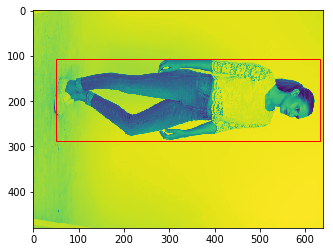

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches
#Verigying before submit
# Create figure and axes
imx = np.random.choice(os.listdir('test/'))
im = cv2.imread('test/' + imx)
im = cv2.cvtColor(im, cv2.COLOR_RGB2GRAY)
#im = np.expand_dims(gray, axis = -1)
fig,ax = plt.subplots(1)
x1 = submission.loc[submission['image_name'] == imx,'x1'].values[0]
x2 = submission.loc[submission['image_name'] == imx,'x2'].values[0]
y1 = submission.loc[submission['image_name'] == imx,'y1'].values[0]
y2 = submission.loc[submission['image_name'] == imx,'y2'].values[0]

# Display the image
#ax.imshow(im[0,:,:,0])
ax.imshow(im)

# Create a Rectangle patch
rect2 = patches.Rectangle((x1,y1),x2-x1,y2-y1,linewidth=1,edgecolor='r',facecolor='none')
# Add the patch to the Axes
ax.add_patch(rect2)

plt.show()

In [18]:
submission.to_csv('submit_resnet50_superaug_9112val.csv', index = False)